# STAT221 Final Project Code

## 2017150470 Seung Hun Han 


In [1]:
import requests
import selenium
import os
import pandas as pd
import selenium
from selenium.webdriver import *

from selenium import webdriver
import time
import sys
from bs4 import BeautifulSoup
import urllib.request
import requests
from lxml import etree, html
from tqdm import tqdm
import torch
import torch.nn as nn
import numpy as np

chrome_driver = 'C:/chromedriver.exe'

C:\Users\icako\anaconda3\envs\py\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\icako\anaconda3\envs\py\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\icako\anaconda3\envs\py\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\icako\anaconda3\envs\py\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device(
    'cpu')

In [3]:
#device=torch.device('cpu')

In [4]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(1998)

In [5]:
sys.path.append('./NewsCrawler/')

In [6]:
from Crawling import content_crawling, crawling
from Processing import Processing, Transform, cleanse, padding

In [7]:
craw=crawling(head='https://sports.news.naver.com/wfootball/news/index?page=',
             start_date='2021-08-01',end_date='2022-05-23') # Scraping function

In [8]:
dataset = pd.read_pickle('./NewsCrawler/Combined_Dataset.pkl') # Read data set

In [21]:
sum(dataset.drop_duplicates()['Total_reaction']==0) #remove duplicates

0

In [9]:
dataset.head(5)

,Date,Title,Total_reaction,Good,Bad
0,2022-02-21,"토트넘, '유베 커넥션' 만든다...이적료 '0원'에 No.10 영입 착수",217.0,192.0,25.0
1,2022-02-21,"케인, 토트넘 종신 '뼈 묻는다'…우승만 할 수 있다면",131.0,70.0,61.0
0,2022-02-21,"'팔꿈치 공격→상대 출혈' 축구 대신 전투 치른 맨유 MF…""퇴장 피한 것 행운""",101.0,22.0,79.0
1,2022-02-21,"'리그 8위' 무리뉴, 애제자 부른다...토트넘은 이적료 '400억' 책정",802.0,142.0,660.0
2,2022-02-21,"'종신맨유' 선언? 데 헤아 ""맨유 떠날 거라곤 생각하지 않아""",118.0,107.0,11.0


In [ ]:
pro = Processing(dataset, colname='Title')
pro.preprocess() #Remove duplicates and null data
x_list, y_list = pro.vectorize() #Tokenize and redefine target values

243  Duplicates removed
0  Null data removed


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='Emotion Category', ylabel='Count'>

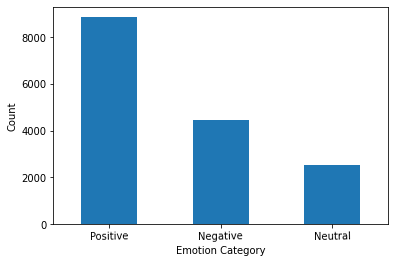

In [66]:
dd=pd.DataFrame(y_list)
ddd=pd.DataFrame(dd.value_counts())
ddd.index=['Positive','Negative','Neutral']
ddd.plot(kind='bar',xlabel='Emotion Category',ylabel='Count',legend=False,rot=1)

In [ ]:
T = Transform(x_list) 
x_list, vocab_size = T.tokenizing(3) #Remove tokens that appeared less than less than 3 times from the vectors
x_list, y_list = cleanse(x_list, y_list) # Remove empty entries
x_list_pad = padding(x_list, pad_size=11, manuel=False) # Maxpadding

In [12]:
for k in range(1,5):
  x_list,vocab_size=T.tokenizing(k)

In [16]:
len(x_list_pad), len(y_list)

(15833, 15833)

In [ ]:
from Models import embed, LSTM
from Model_Fitting import LSTM_Best

embedding_opt = [50, 100, 150]
hidden_opt = [50, 100, 150]
layers_opt = [1, 2, 3]
dic,test_x,test_y=LSTM_Best(vocab_size,  #LSTM hyperparameter tuning
          embedding_opt,
          hidden_opt,
          layers_opt,
          x_list_pad,
          y_list,
          nfolds=20,
          nepochs=30)

In [14]:
pd.read_csv('Parameter_selection.csv').head(10) # Hyperparameter tuning result.

,hidden_units,n_layers,loss_train,loss_val,acc_train,acc_val
0,50,1,0.603808,0.603848,0.762752,0.762704
1,50,2,0.712952,0.674069,0.693423,0.715021
2,50,3,0.947004,0.939851,0.567449,0.571295
3,100,1,0.545076,0.545108,0.796967,0.796957
4,100,2,0.658554,0.618208,0.724336,0.746585
5,100,3,0.972176,0.972211,0.562246,0.562214
6,150,1,0.671885,0.671942,0.729800,0.729791
7,150,2,0.923146,0.919720,0.562507,0.562214
8,150,3,0.971697,0.971413,0.562279,0.562214
9,50,1,0.113136,0.113122,0.989347,0.989353


embedding size=100, hidden unit=100 n_layer=2 is the most optimal

Now that I know optimal hyperparameter settings, I will modify each layers of model to relieve overfitting.

Layer 1: Embedding
Layer 2: Dropout
Layer 3

In [67]:
from Predict import Best_model_LSTM

In [68]:
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

In [70]:
batch_size=32 
epochs=10
splits=15

In [73]:
train_x_set, test_x_set, train_y_set, test_y_set = train_test_split(x_list_pad,y_list, test_size=0.1, shuffle=True)

In [74]:
from sklearn.model_selection import KFold
from tqdm import tqdm
split = KFold(n_splits=splits, shuffle=True, random_state=True) #15 fold validation

In [81]:
lstm=Best_model_LSTM(vocab_size,embedding_num=20,
                         hidden_units=100,
                         nlayers=2,
                         nclass=3,drop=0.60) #Defining model
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.01,weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                                            lr_lambda=lambda epoch: 0.95 ** epoch,
                                                            last_epoch=-1,
                                                            verbose=False)
criterion = torch.nn.CrossEntropyLoss() # 분류

In [78]:
loss_train_all = []
loss_val_all = []
each_fold_train_acc = []
each_fold_val_acc = []
best_acc = 0
train_accuracy_each_epoch=0
val_accuracy_each_epoch=0    
train_y_set=torch.tensor(train_y_set).to(device)
    
for i in tqdm(range(epochs)):
    count=0
    count_val=0
    train_accuracy_each_epoch=0
    train_loss_record=0

    val_accuracy_each_epoch=0  
    val_loss_record=0
    for train_idx,val_idx in split.split(train_x_set,train_y_set):
        train_x, train_y = train_x_set[train_idx], train_y_set[train_idx]
        val_x, val_y = train_x_set[val_idx], train_y_set[val_idx]
        count+=len(train_x)
        count_val+=len(val_x)
        train_x=np.array(train_x)
        val_x=np.array(val_x)        

        
        scores=lstm(train_x)
        loss = criterion(scores, train_y)
        train_loss_record += (loss.item())        
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        scheduler.step()

        train_accuracy_each_epoch+=(sum(scores.argmax(axis=1)==train_y.argmax(axis=1))).item()
    
        with torch.no_grad():
            scores2 = lstm(val_x)
            val_loss_record += criterion(scores2, val_y).item()
            epoch_acc=(sum(scores2.argmax(axis=1)==val_y.argmax(axis=1))).item()
            val_accuracy_each_epoch+=epoch_acc
        
    train_accuracy_each_epoch=train_accuracy_each_epoch/count

    val_accuracy_each_epoch=val_accuracy_each_epoch/count_val
        
    if best_acc < val_accuracy_each_epoch:
        best_acc = val_accuracy_each_epoch
        print('Best Accuracy is: ', best_acc)
        torch.save(lstm.state_dict(),'C:/Users/icako/NewsCrawler/best_model.pth')
        print('Model Saved.')
    
    
    
    loss_train_all.append(train_loss_record/len(train_x))
    loss_val_all.append(val_loss_record/len(val_x))

    each_fold_train_acc.append(train_accuracy_each_epoch)
    each_fold_val_acc.append(val_accuracy_each_epoch)
    
    print("Train Acc is: ",train_accuracy_each_epoch)
    print("Val Acc is: ",val_accuracy_each_epoch)    
    print("Train Loss is: ",train_loss_record/len(train_x))
    print("Val Loss is: ",val_loss_record/len(val_x)) 

C:\Users\icako\AppData\Local\Temp\ipykernel_33880\3121536716.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y_set=torch.tensor(train_y_set).to(device)
  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 342.00 MiB (GPU 0; 2.00 GiB total capacity; 978.49 MiB already allocated; 2.50 MiB free; 1.15 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [82]:
checkpoint=torch.load('C:/Users/icako/NewsCrawler/best_modelLSTMfinal.pth') # Load the best model
lstm.load_state_dict(checkpoint) 
lstm.eval()

Best_model_LSTM(
  (layer1): Embedding(5227, 100, padding_idx=0)
  (layer2): LSTM(100, 100, num_layers=2, batch_first=True, dropout=0.6)
  (layer3): Linear(in_features=100, out_features=3, bias=True)
)

In [83]:
pred_y=lstm(test_x_set).argmax(axis=1).to(torch.device('cpu'))
origin_y=torch.tensor(test_y_set).to(torch.device('cpu')).argmax(axis=1)

RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [123]:
sum(pred_y==origin_y).item()/len(origin_y)  #Test accuracy

0.6767676767676768

In [84]:
records=pd.read_csv('Train_record.csv')

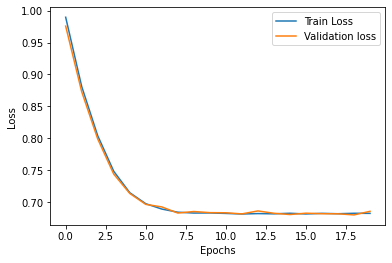

In [85]:
plt.plot(records['Train_loss'],label='Train Loss')
plt.plot(records['Val_loss'],label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

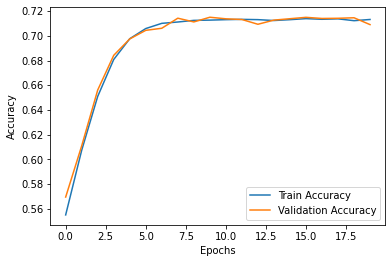

In [86]:
plt.plot(records['Train_acc'],label='Train Accuracy')
plt.plot(records['Val_acc'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [190]:
def predict(input): #Predict reader response when a title is computed
    from konlpy.tag import Okt
    import re
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.preprocessing.text import Tokenizer

    stopwords = pd.read_csv(
                    "https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()

    hangul=re.compile('[^ ㄱ-ㅣ 가-힣]')
    hangul.sub('',input)
    okt=Okt()
    tokens=okt.morphs(input)
    removal=[x for x in tokens if x not in stopwords]
    removal=[x for x in tokens if len(x)>1]

    predicttokenizer=Tokenizer()
    predicttokenizer.fit_on_texts(removal)
    vocab_size_predict=len(predicttokenizer.word_counts.items())
    predict_x=T.tokenizer.texts_to_sequences([removal])
    predict_x = [sentence for sentence in predict_x if len(sentence) > 0]
    predict_x=pad_sequences(predict_x,maxlen=10)
    predict_x=np.array(predict_x)
    prob=(torch.nn.functional.softmax(lstm(predict_x))).view(-1)
    predict_y=torch.argmax(prob)
    
    print("Expected Sentiment is :", predict_y.item(), 'predict_y with probability of', round(prob[predict_y].item(),2)) 

In [39]:
pd.DataFrame((test_y_set.argmax(axis=1))).value_counts() #DIstribution of test label dataset

2    874
0    460
1    250
dtype: int64

In [40]:
pd.DataFrame(pred_y).value_counts() #Distribution of fitted test label data

2    1122
0     372
1      90
dtype: int64

In [74]:
train_pred=lstm(x_list_pad).argmax(axis=1).to(torch.device('cpu'))
train_target=torch.tensor(y_list).argmax(axis=1).to(torch.device('cpu'))

C:\Users\icako\./NewsCrawler\Predict.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xembedded = torch.tensor(xembedded).to(device)


In [100]:
confusion=pd.concat([pd.DataFrame(train_pred),pd.DataFrame(train_target)],axis=1)
confusion.columns=['Fitted','Real']
matrix_conf=confusion_matrix(confusion['Real'],confusion['Fitted'])
matrix_conf=matrix_conf/np.sum(matrix_conf,axis=0)
confusionmatrix=pd.DataFrame(matrix_conf, 
             index=['Negative',  'Neutral','Positive'],
             columns=['Negative', 'Neutral','Positive'])

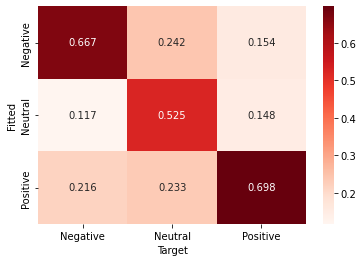

In [119]:
import seaborn as sns
sns.heatmap(confusionmatrix, annot = True, fmt = '.3f',cmap = 'Reds') # Confusion matrix
plt.xlabel('Target')
plt.ylabel('Fitted')

plt.show()

In [173]:
np.random.randint(0,len(dataset),5)

array([ 3935, 15256,  7553,  4578,  1246])

In [187]:
import warnings
warnings.filterwarnings(action='ignore')

In [197]:
randomtitle=dataset.reset_index(drop=True)['Title'][np.random.randint(0,len(dataset),5)]
for i in randomtitle:
    print(i,'\n\n',predict(i))

Expected Sentiment is : 2 predict_y with probability of 0.47
'아직 살아있네!'...골 냄새 맡은 호날두, 순간 스피드 '32.5km/h' 

 None
Expected Sentiment is : 0 predict_y with probability of 0.68
'90% 출전' 붙박이 주전 MF, 맨유 감독 교체 후 선발 제외 

 None
Expected Sentiment is : 0 predict_y with probability of 0.69
"메시는 숲의 할아버지, WC서 벤치" 前 폴란드대표팀 감독 감 떨어진 것 아냐? 

 None
Expected Sentiment is : 2 predict_y with probability of 0.92
[오피셜] 맨유, 랑닉 사단으로 변신...수석코치 샤프 등 3명 선임 

 None
Expected Sentiment is : 1 predict_y with probability of 0.43
“좋은 스쿼드야! 2부 리그에선” 팬들 분노…아스널 21-22 시즌 라인업 

 None


In [212]:
predict('실축만 3번, 나이가 야속한 호날두')

Expected Sentiment is : 2 predict_y with probability of 0.51


In [13]:
from transformers import AutoTokenizer, AutoModel
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import BertModel
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import BertModel

In [14]:
dataset.drop_duplicates(inplace=True)
dataset['Emotion_Ratio']=0
dataset.loc[dataset['Bad']==0,'Bad']=0.1 #Dealing with situation when there is no "bad" reaction
dataset['Emotion_Ratio']=dataset['Good']/dataset['Bad']
dataset.loc[dataset['Emotion_Ratio']>=2,'Emotion_Ratio']=2
dataset.loc[(dataset['Emotion_Ratio'] < 2) & (dataset['Emotion_Ratio'] >=0.5),'Emotion_Ratio']=1
dataset.loc[dataset['Emotion_Ratio'] < 0.5,'Emotion_Ratio']=0

In [15]:
import tensorflow

In [16]:
dataset_shuffled = dataset.sample(frac=1).reset_index(drop=True)
train = dataset_shuffled[:12000]
test = dataset_shuffled[12000:] # Splitting train and test dataset

In [17]:
sentences = ["[CLS] " + str(s) + " [SEP]" for s in train.Title]

In [18]:
labels=tensorflow.keras.utils.to_categorical(train['Emotion_Ratio'].values)

In [19]:
import pandas as pd
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(s) for s in sentences] #Use pretrained bert for tokenizing

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 11
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [24]:
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [28]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=2000, 
                                                                                    test_size=0.2)

In [29]:
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=2000, 
                                                       test_size=0.2)  

In [30]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)  

In [31]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = torch.utils.data.RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = torch.utils.data.SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [32]:
sentences = ["[CLS] " + str(s) + " [SEP]" for s in test.Title]

# 라벨 데이터
labels = tensorflow.keras.utils.to_categorical(test['Emotion_Ratio'])

# Word 토크나이저 토큰화
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# 시퀀스 설정 및 정수 인덱스 변환 & 패딩
MAX_LEN = 11
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# 어텐션 마스크
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
    
# 파이토치 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

# 배치 사이즈 설정 및 데이터 설정
batch_size = 32
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = torch.utils.data.RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [33]:
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [34]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # 학습률(learning rate)
                  eps = 1e-8,weight_decay=0.0001
                )

# 에폭수
epochs = 20

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [35]:
def flat_accuracy(preds, labels):
    
    pred_flat = torch.argmax(preds, axis=1).flatten()
    labels_flat = torch.argmax(labels,axis=1)

    return torch.sum(pred_flat == labels_flat) / len(labels_flat)
    
criterion = torch.nn.CrossEntropyLoss() # 분류


In [36]:
model=model.to(device)

In [37]:
train_acc_list=[]
val_acc_list=[]
model.zero_grad()
best_acc=0
total_loss_list=[]
total_loss_val_list=[]
# 학습
for epoch_i in tqdm(range(0, epochs)):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 로스 초기화
    total_loss = 0
    total_loss_val=0
    # 훈련모드로 변경
    model.train()
    train_acc=0
    val_acc=0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(tqdm(train_dataloader)):
        # 경과 정보 표시

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels).logits
        
        # 로스 구함
        loss = criterion(outputs,b_labels)

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()
        train_acc+=flat_accuracy(outputs,b_labels).item()
        
    train_acc_list.append(train_acc/len(train_dataloader))
        
    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            
    total_loss_list.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask).logits
        
        # 로스 구함
        loss = criterion(outputs,b_labels)
        total_loss_val += loss.item()
        val_acc+=flat_accuracy(outputs,b_labels).item()
        
    avg_val_loss = total_loss_val / len(validation_dataloader)            
    total_loss_val_list.append(avg_val_loss)
    print("")
    print("  Average validation loss: {0:.2f}".format(avg_val_loss))
    
    val_acc_save=val_acc/len(validation_dataloader)
    val_acc_list.append(val_acc_save)
        
    
    if best_acc < val_acc_save:
        best_acc = val_acc_save
        print('Best Accuracy is: ', best_acc)
        torch.save(model.state_dict(),'C:/Users/icako/NewsCrawler/best_model_BERT.pth')
        print('Model Saved.')
        
print("")
print("Training complete!")

  0%|          | 0/20 [00:00<?, ?it/s]


======== Epoch 1 / 20 ========
Training...



  0%|          | 0/20 [00:02<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 352.00 MiB (GPU 0; 2.00 GiB total capacity; 1014.13 MiB already allocated; 156.50 MiB free; 1.07 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [41]:
checkpoint=torch.load('C:/Users/icako/NewsCrawler/best_model_BERT.pth') # Load the best model
model.load_state_dict(checkpoint) 
model.eval() 

RuntimeError: CUDA out of memory. Tried to allocate 352.00 MiB (GPU 0; 2.00 GiB total capacity; 1013.02 MiB already allocated; 156.50 MiB free; 1.07 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [40]:
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(tqdm(test_dataloader)):
    # 경과 정보 표시

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask).logits
    
    # 로스 구함
    loss += criterion(outputs,b_labels)

    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(outputs, b_labels)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1


print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))

loss_test=loss/len(test_dataloader)

100%|██████████| 120/120 [00:11<00:00, 10.28it/s]


Accuracy: 0.28
